# Temperaturas Ciudades

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

plt.rcParams["figure.figsize"] = (16, 10)

In [20]:
df = pd.read_csv('data/CitiesWithAltitude.csv',parse_dates = [0])

# Tengo que agarrar del año 1841 en adelante
df = df[df['date'] >= datetime(1841,1,1)]
df.sort_values(['date','country','city'], inplace = True)

df['ordinal']= df['date'].apply(lambda x: x.toordinal())
print(df.head())

groupByCountries = df.groupby('country')
groupByCities = df.groupby('city')
#Ojo! la funcion magica necesita estos groupby

             date    avg  error      city  country   long    lat  season  \
130983 1841-01-01  7.673  2.429   Elbasan  Albania  19.17  40.99       4   
1034   1841-01-01  7.673  2.429    Tirana  Albania  19.17  40.99       4   
169157 1841-01-01 -5.310  2.242    Gyumri  Armenia  44.73  40.99       4   
30261  1841-01-01 -5.310  2.242  Vanadzor  Armenia  44.73  40.99       4   
35862  1841-01-01 -5.310  2.242   Yerevan  Armenia  44.73  40.99       4   

        hemisphere  altitude  ordinal  
130983           1       126   672047  
1034             1       103   672047  
169157           1      1545   672047  
30261            1      1320   672047  
35862            1      1002   672047  


## FUNCION MAGICA!

In [21]:
# PARAMETROS
#city: nombre de la ciudad que quiero predecir
#ciudadesData: lista de las ciudades que voy a utilizar para predecir
#yrAndQttyTraining: lista que tiene [año para comenzar en training, cant de años de training]
#yrAndQttyPred: lista que tiene 
#         [año para comenzar a predecir(se supone que el sig del training), cant de años de prediccion]
#varList: lista con los nombres de las variables a utilizar ej.: ['avg', 'ordinal']
#funcion: para pasarle a cml

# DEVUELVE TUPLA
#funCML: funcion de cml
#dicXsT: los xs de cada ciudad (o sea los puntos para la funcion cml) de training
#ysT: la lista de las temperaturas en el periodo de training
#fechasT: rango de fechas de training
#dicResT: diccionario con los resultados de evaluar XsT con funT
#ecmT: ECM de la etapa de training
#dicXsP:los xs de cada ciudad (o sea los puntos para la funcion cml) de prediction
#ysP: la lista de las temp en el periodo de prediction
#fechasP: rango de fechas de prediction
#dicResP: diccionario con los resultados de evaluar XsP con funT
#ecmP: ECM de la etapa de prediction

def foo(city, ciudadesData, yrAndQttyTraining, yrAndQttyPred, varList, funcion):
    #PARSEO DATOS:
    dfCity = pd.DataFrame(groupByCities.get_group(city))
    dicDfCiudades = {}
    for c in ciudadesData:
        dicDfCiudades[c] = pd.DataFrame(groupByCities.get_group(c))

    #TRAINING DATA:
    dfCityT = dfCity.copy(deep=True)
    dicDfCT = {}
    for k,v in dicDfCiudades.items():
        dicDfCT[k] = v.copy(deep=True)
    
    #parseo fechas
    yearT = yrAndQttyTraining[0]
    qttyYrT = yrAndQttyTraining[1]
    dateSinceT = datetime(yearT, 1, 1)
    dateToT = dateSinceT + relativedelta(years=+qttyYrT)
    dfCityT = dfCityT[dfCityT['date'] >= dateSinceT]
    dfCityT = dfCityT[dfCityT['date'] < dateToT]
    for k,v in dicDfCT.items():
        v = v[v['date'] >= dateSinceT]
        v = v[v['date'] < dateToT]
        dicDfCT[k] = v
    
    dicVarT = {}
    for k,v in dicDfCT.items():
        dicVarT[k] = []
        for var in varList:
            dicVarT[k].append(list(v[var]))
            #print("var "+ var + " = ", list(v[var]))
            #print("len var " + var + " = ", len(list(v[var])))
    #print(dicVarT)

    dicXsT = {}
    for k,v in dicVarT.items():
        xs = []
        for i in range(len(v[0])):
            tupla = []
            for j in range(len(v)):
                tupla.append(v[j][i])
                #print("i* = ", i)
                #print("j = ", j)
            xs.append(tupla)
            #print(tupla)
        #print("xs = ", xs)
        dicXsT[k] = xs
        #print(dicXsT)

    xsT = []
    for k,v in dicXsT.items():
        xsT = xsT + v
    #print(xsT)

    ys = list(dfCityT['avg'])
    ysT = []
    for i in range(len(ciudadesData)):
        ysT = ysT + ys
    #print("ysT = ", ysT)
    
    # obtengo cml y evaluo con los xsT y ysT
    funCML = cml(funcion, xsT, ysT)
    dicResT = {}
    for k,v in dicXsT.items():
        res = [funCML(x) for x in v]
        dicResT[k] = res
        
    
    #PREDICTION DATA
    dfCityP = dfCity.copy(deep=True)
    dicDfCP = {}
    for k,v in dicDfCiudades.items():
        dicDfCP[k] = v.copy(deep=True)
    
    #parseo fechas
    yearP = yrAndQttyPred[0]
    qttyYrP = yrAndQttyPred[1]
    dateSinceP = datetime(yearP, 1, 1)
    dateToP = dateSinceP + relativedelta(years=+qttyYrP)
    dfCityP = dfCityP[dfCityP['date'] >= dateSinceP]
    dfCityP = dfCityP[dfCityP['date'] < dateToP]
    for k,v in dicDfCP.items():
        v = v[v['date'] >= dateSinceP]
        v = v[v['date'] < dateToP]
        dicDfCP[k] = v
    
    dicVarP = {}
    for k,v in dicDfCP.items():
        dicVarP[k] = []
        for var in varList:
            dicVarP[k].append(list(v[var]))
    
    dicXsP = {}
    for k,v in dicVarP.items():
        xs = []
        for i in range(len(v[0])):
            tupla = []
            for j in range(len(v)):
                tupla.append(v[j][i])
            xs.append(tupla)
        dicXsP[k] = xs

    xsP = []
    for k,v in dicXsP.items():
        xsP = xsP + v
    
    ys2 = list(dfCityP['avg'])
    ysP = []
    for i in range(len(ciudadesData)):
        ysP = ysP + ys2
    
    dicResP = {}
    for k,v in dicXsP.items():
        res = [funCML(x) for x in v]
        dicResP[k] = res
    
    #print(len(xsP))
    #print(len(ysP))
    
    return (funCML, dicXsT, ys, list(dfCityT['date']), dicResT, dicXsP, ys2, list(dfCityP['date']), dicResP)
    #return 1

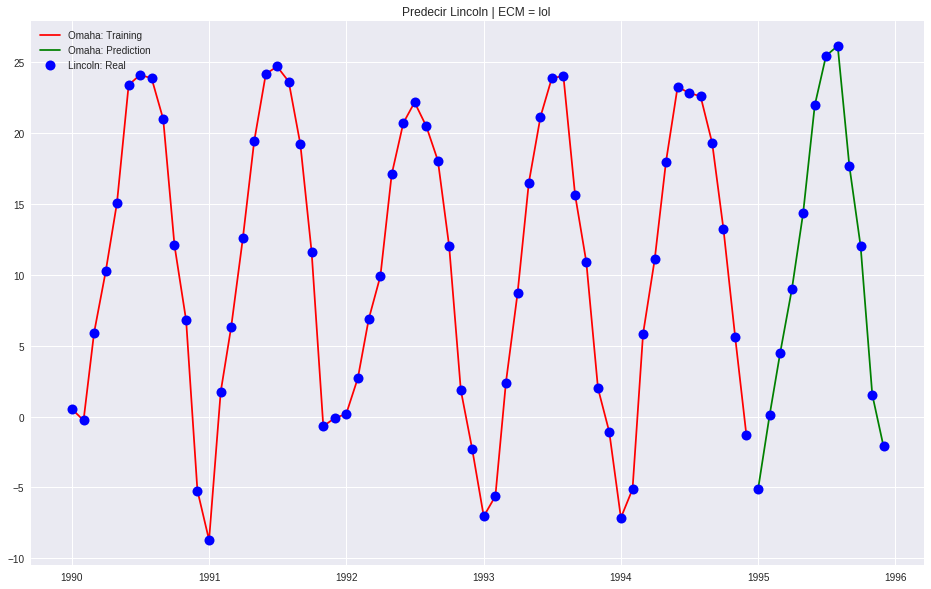

In [22]:
gUsa = pd.DataFrame(groupByCountries.get_group('United States'))
#print(gUsa.head())

cities = list(set(gUsa['city']))
#print(cities)

city = 'Lincoln'
ciudadesData = ['Omaha']
yrAndQttyTraining = [1990,5]
yrAndQttyPred = [1995,1]
varList = ['avg', 'ordinal']
funcion = lambda x: [x[0], x[1], 1]

funCML,dicXsT,ysT,fechasT,dicResT,dicXsP,ysP,fechasP,dicResP = foo(city, ciudadesData, yrAndQttyTraining, yrAndQttyPred, varList, funcion)

#imprimo
plt.plot(fechasT, dicResT['Omaha'], 'r', label=ciudadesData[0]+': Training', color='red')
plt.plot(fechasP, dicResP['Omaha'], 'r', label=ciudadesData[0]+': Prediction', color='green')

plt.plot(fechasT+fechasP, ysT+ysP, 'o', label=city+': Real', markersize=10, color='blue')

plt.title('{} | ECM = {} '.format("Predecir "+ city, 'lol') )
plt.legend()

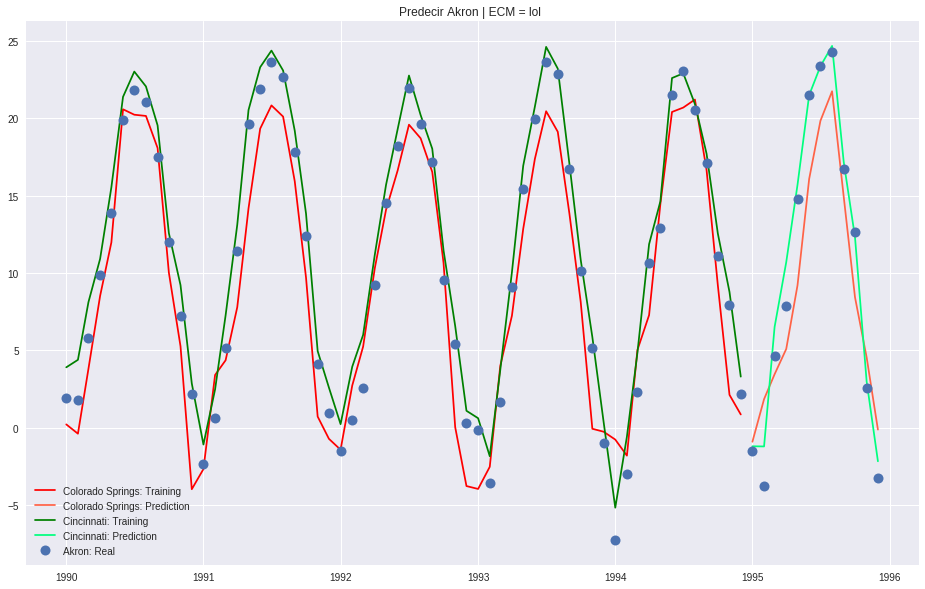

In [23]:
gUsa = pd.DataFrame(groupByCountries.get_group('United States'))
#print(gUsa.head())

cities = list(set(gUsa['city']))
#print(cities)

# Tomo cities[0] y cities[1] con ellas intento predecir cities[2]
city = cities[2]
ciudadesData = [cities[0], cities[1]]
yrAndQttyTraining = [1990,5]
yrAndQttyPred = [1995,1]
varList = ['ordinal', 'avg']
funcion = lambda x: [x[0], x[1], 1]

funCML,dicXsT,ysT,fechasT,dicResT,dicXsP,ysP,fechasP,dicResP = foo(city, ciudadesData, yrAndQttyTraining, yrAndQttyPred, varList, funcion)


#imprimo
plt.plot(fechasT, dicResT[ciudadesData[0]], 'r', label=ciudadesData[0]+': Training', color='red')
plt.plot(fechasP, dicResP[ciudadesData[0]], 'r', label=ciudadesData[0]+': Prediction', color='tomato')

plt.plot(fechasT, dicResT[ciudadesData[1]], 'r', label=ciudadesData[1]+': Training', color='green')
plt.plot(fechasP, dicResP[ciudadesData[1]], 'r', label=ciudadesData[1]+': Prediction', color='springgreen')

plt.plot(fechasT+fechasP, ysT+ysP, 'o', label=city+': Real', markersize=10)

plt.title('{} | ECM = {} '.format("Predecir "+ city, 'lol') )
plt.legend()